In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()

import scipy
from time import time
import scipy.linalg as sla

randn = np.random.randn

def chern_torus(W=5, L=5):

    disorder_potential = randn(W, L)

    def shape(pos):
        (x, y) = pos
        return (0 <= x < W) * (0 <= y < L)

    def onsite(site, p):
        t, mu, dis_amplitude = p.t, p.mu, p.disorder
        (x, y) = site.pos
        return (4 * t - mu) * pauli.sz

    def hopx(site1, site2, p):
        t, delta = p.t, p.delta
        return -t * pauli.sz + 1j * p.delta * pauli.sx

    def hopy(site1, site2, p):
        t, delta = p.t, p.delta
        return -t * pauli.sz - 1j * p.delta * pauli.sy

    lat = kwant.lattice.square()
    sys = kwant.Builder()
    sys[lat.shape(shape, (0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy
    sys[kwant.HoppingKind((-W + 1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, -L + 1), lat)] = hopy
    return sys.finalized()

def projected_operators(sys, p, energy=0):
    pos = np.array([sys.pos(i) for i in range(sys.graph.num_nodes)])
    x, y = pos.T
    # Double all entries to take orbitals into account.
    x = np.resize(x, (2, len(x))).T.flatten()
    y = np.resize(y, (2, len(y))).T.flatten()
    x *= 2 * np.pi / (np.max(x) + 1)
    y *= 2 * np.pi / (np.max(y) + 1)
    op_x = np.diag(np.exp(1j * x))
    op_y = np.diag(np.exp(1j * y))

    ham = sys.hamiltonian_submatrix(args=[p])
    ham -= 0 * np.identity(len(ham))
    energies, states = np.linalg.eigh(ham)

    projector = states[:, energies < energy]

    op_x = projector.T.conj().dot(op_x).dot(projector)
    op_y = projector.T.conj().dot(op_y).dot(projector)
    return op_x, op_y


def two_terminal(L, W):
    t = 1.0

    def shape(pos):
        (x, y) = pos
        return (0 <= y < W and 0 <= x < L)

    def lead_shape(pos):
        (x, y) = pos
        return (0 <= y < W)

    lat = kwant.lattice.square()
    sys = kwant.Builder()

    # definition of system
    sys[lat.shape(shape, (0, 0))] = 3 * t
    sys[kwant.HoppingKind((1, 0), lat)] = -t
    sys[kwant.HoppingKind((0, 1), lat)] = -t

    # definition of leads
    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))
    lead[lat.shape(lead_shape, (0, 0))] = 3 * t
    lead[kwant.HoppingKind((1, 0), lat)] = -t
    lead[kwant.HoppingKind((0, 1), lat)] = -t

    # attaching leads
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    return sys.finalized()


def diag_time(N):
    sys = two_terminal(N, N)

    start = time()
    ham = sys.hamiltonian_submatrix()
    ev, evec = sla.eigh(ham)
    res = time() - start
    return res


def smat_time(N):
    sys = two_terminal(N, N)

    start = time()

    smat = kwant.smatrix(sys)

    res = time() - start
    return res

Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

**No content above this line is visible in edX**

# Introduction

Fabian Hassler from RWTH Aachen will present the topological invariants

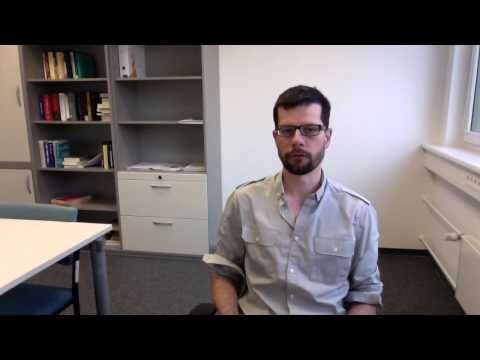

In [2]:
MoocVideo("ceyus0cRBi0", src_location="8.2-intro")

# Applications of topological invariants

Throughout the course we computed several times a topological invariant of different systems. When is calculating a topological invariant useful or necessary?

The toy model Hamiltonians that we considered do not really require a complicated calculation set up to figure out whether they are topological or not. However, there are two types of applications where a heavy duty algorithm is important. These are:

* Ab-initio band structures calculations
* Disordered systems

So, we start with a Hamiltonian of some complicated material, and we want to know if it is topological or not. What's worse is that we don't even know in advance if it is gapped or not! If the system is disordered (you'll learn more about those next week), then in addition we can never simulate a truly infinite system. What we can do is to take chunks of finite size  and hope that it behaves correctly like an infinite system once the sample size is large enough.

This Hamiltonian may have many parameters, so it's a large $N\times N$ matrix. For systems with a complicated band structure, $N$ is fixed to be the number of orbitals we need to faithfully approximate the Hamiltonian, while in disordered systems we would usually simulate a finite system with linear size $L$, and so $N=L^d$, with $d$ the dimensionality of the space.

There's a simple rule which allows us to guess how large a disordered system should be, in order to correctly reproduce the topology of an infinite system.

> If the typical decay length of the state at the Fermi level of a disordered system is $\xi$, then we need to take a sample with $L \gtrsim \xi$ to correctly calculate its topological properties.

The reason why this is true is that in a smaller sample the bulk is not 'insulating enough'.

So now we know that the main problem is that we need to do something with a large matrix.

# Computational costs

How expensive are the calculations? If you look in the literature, you'll see wildly differently looking algorithms bundled together with different claims of performance. There is actually a very simple way to figure out, and it comes down to an almost universally correct empirical rule:

> Whenever you need to do something with a dense matrix of size $M\times M$ in a numerical calculation, the costs of doing it most likely are $\sim M^3$.

This is true almost no matter what you do: matrix multiplication, inversion, diagonalization, calculation of a determinant, and dozens of other decompositions all cost the same. The specific value of the numerical prefactor does vary.

The things become more complicated when the Hamiltonian becomes sparse, since then one may efficiently use that most entries in the matrix are zero. For example, multiplying two $M\times M$ banded matrices has a cost $~M$, instead of $M^3$.

Part of our intuition stays true. So since after diagonalizing a Hamiltonian we obtain an $M\times M$ matrix of eigenvectors, typically we still need to perform $\sim M^3$ number of operations.

A scattering matrix is smaller than the matrix of all the eigenvectors, and for our sample with a linear size $L$, the size of the scattering matrix is $L^{d-1}$, as opposed to $L^d$, the size of the Hamiltonian. While this fact isn't [trivial](http://en.wikipedia.org/wiki/LU_decomposition#Sparse_matrix_decomposition) at [all](http://en.wikipedia.org/wiki/Nested_dissection), calculation of a scattering matrix still costs the cube of its size, so $L^{3d-3}$.

This difference is most pronounced in 2D systems, where the cost of diagonalization results in more than an order of magnitude difference in the system size. On most modern computers diagonalization works up to system sizes of $\sim 100$, and scattering matrix calculations work up to system sizes of $\sim 1000$. This can be best seen over here (but you can also test for yourself):

In [3]:
Ns_diag = np.logspace(1, np.log10(80), 5)[:4]
diag_times = [diag_time(N) for N in Ns_diag]

Ns_smat = np.logspace(1, 3, 10)[:6]
smat_times = [smat_time(N) for N in Ns_smat]

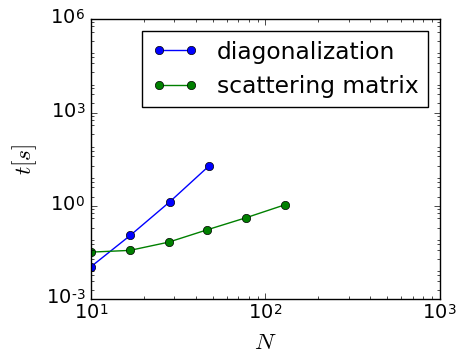

In [4]:
plt.plot(Ns_diag, diag_times, '-o', label='diagonalization')
plt.plot(Ns_smat, smat_times, '-o', label='scattering matrix')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$N$')
plt.ylabel('$t [s]$')
plt.ylim(10**-3,10**6)
plt.yticks([1e-3, 1, 1e3, 1e6])
plt.legend()
plt.show()

## Momentum integration

As you saw, unless we're lucky, a topological invariant is a $d$-dimensional integral of something like winding number density or Berry curvature. If we deal with the scattering matrix, the Brillouin zone is once again reduced by one dimension, and the integral becomes $(d-1)$-dimensional.

How many points in momentum space do we need? If we are integrating Berry curvature, we want the uncertainty of the integral to be $\lesssim .5$, so that we can round it and get the correct answer. That means that if there's a Dirac point with a small gap, we need to resolve it in momentum space, and the number of points should scale as $\sim(1/\xi)^d$.

If we consider a disordered system, we must consider a finite system of a large enough size $L \gtrsim \xi$, so that every point on the Brillouin zone is representative, and we just need a single point to effectively estimate the value of the integral (you'll see later how to do this in one of the techniques).

So let's take a system with $N$ orbitals in a unit cell, and edge state decay length $\xi$. The cost of computing the topological invariant is:

* $\sim (N/\xi)^{3d}$ for disordered systems using the full spectrum.
* $\sim N^3 / \xi^d$ for band structures using the full spectrum.
* $\sim (N/\xi)^{3d-3}$ for disordered systems using scattering approach.
* $\sim N^3 / \xi^{d-1}$ for band structures using scattering approach.

# A special thing about 1D

There is a special feature of topological invariants in 1D, that dramatically speeds up a calculation. It's a computational trick that is so elegant and universal that we'd like to share it.

You might remember studying the SSH chain back in week one. This is a similar system to the Majorana chain, but it is characterized by chiral symmetry rather than particle-hole symmetry.

A 1D Bloch Hamiltonian $H(k)$ with chiral symmetry has the form

$$
H(k) = \begin{pmatrix} 0 & h(k) \\
h^\dagger(k) & 0\end{pmatrix},
$$

with $h(k) = h_0 + t_L e^{ik} + t_R e^{-ik}$ a matrix containing the onsite term $h_0$, the left hopping $t_L$ and the right hopping $t_R$.

If you look up the table, this Hamiltonian is characterized by a $\mathbb{Z}$ topological invariant. This invariant is the  [winding number](http://en.wikipedia.org/wiki/Winding_number) that Fabian Hassler discussed in the introductory video. Let's again describe its meaning.

We need to find an integer quantity which can only change when the gap of $H(k)$ closes. Now, $H(k)$ can only have a zero eigenvalue if $h(k)$ does, that is if $\det [h(k)]=0$. For a gapped Hamiltonian, $\det [h(k)]$ will in general be a complex number other than zero for all values of $k$.

Let us now try to picture the path that $h(k)$ takes in the complex plane as $k$ is varied from $0$ to $2\pi$. This path must be closed, because $\det [h(0)]$ must be equal to $\det [h(2\pi)]$, and avoid the origin. We may therefore ask: how many times does the path go around the origin? This number must be integer, and it cannot change unless we make the path go through zero. It is our $\mathbb{Z}$ topological invariant, because we can distinguish a clockwise path from a counterclockwise path.

The mathematical expression for the winding number is more obscure than its meaning:

$$
Q(H) = \frac{1}{2\pi i}\,\int_0^{2\pi} dk\,\frac{d}{dk}\,\log\,\det[h(k)],
$$

but it just counts how much the phase of $\det h$ increases as $k$ goes through the Brillouin zone.

How to take this integral? The trick is to use analytic continuation to a complex plane.

As $k$ varies from $0$ to $2\pi$, $e^{ik}$ goes around the unit circle in the complex plane. Let's now make a substitution $e^{ik}\,\to\,z$, with $z$ a complex number. The determinant $\det[h(k)]$ becomes a polynomial function in $z$, $f(z) = \det[h_0 + z\, t_L + z^{-1}\, t_R]$. We now need to compute the following integral on the unit circle 

$$
Q(H) = \frac{1}{2\pi i}\,\oint dz \,\frac{d}{dz} \log f(z) = \frac{1}{2\pi i}\,\oint\,dz\,\frac{f'(z)}{f(z)}.
$$

We can now use a nice result from complex analysis, the [argument principle](http://en.wikipedia.org/wiki/Argument_principle). It tells us that each zero of $f(z)$ inside the unit circle contributes $+1$ to the value of $Q(H)$, and each pole contributes $-1$. Hence, by counting the number of zeros and poles of $f(z)$ inside the unit circle we immediately get the winding number. So, we have reduced the calculation of the topological invariant to finding zeros and poles of the expression $\det[h_0 + z\, t_L + z^{-1}\, t_R]=0$. The poles are trivial to find, and they are all located at $z=0$.

To find the zeros we notice that we need to solve a problem

$$[z h_0 + z^2 t_L + t_R]\psi = 0.$$

This is a [polynomial eigenvalue problem](http://en.wikipedia.org/wiki/Nonlinear_eigenproblem), and it is trivially mapped onto a standard eigenvalue problem.

$$
z\begin{pmatrix}
h_0 & t_L \\
1 & 0
\end{pmatrix} \psi' = 
\begin{pmatrix}
- t_r & 0\\
0 & 1
\end{pmatrix} \psi'.
$$

So by finding all the eigenvalues $z$ we get all the zeros of $h(z)$ inside the unit circle, and immediately obtain the 1D topological invariant:

b':HoloMap   [Default]\n   :Overlay\n      .Path.I    :Path   [$\\operatorname{Re}(z)$,$\\operatorname{Im}(z)$]\n      .Points.I  :Points   [x,y]\n      .Points.II :Points   [x,y]'
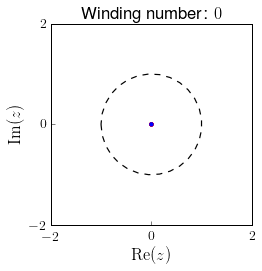
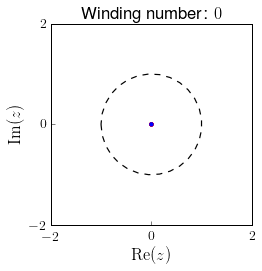
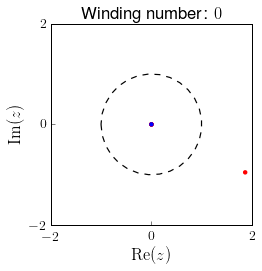
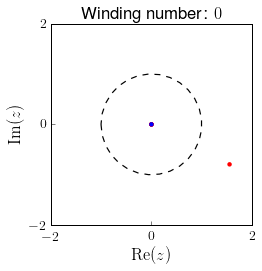
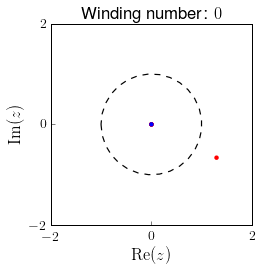
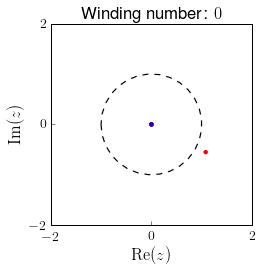
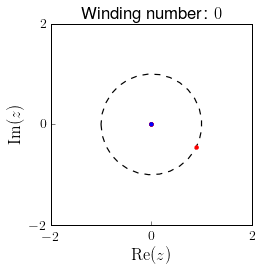
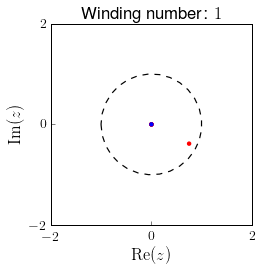
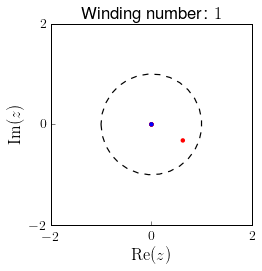
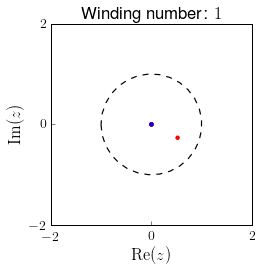
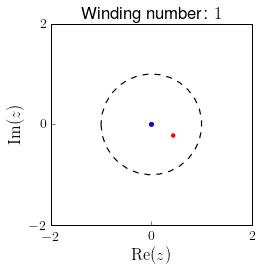
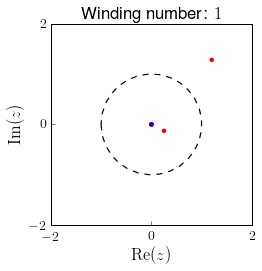
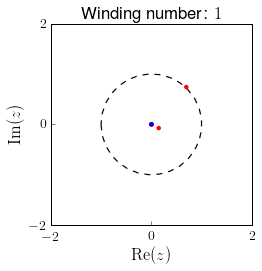
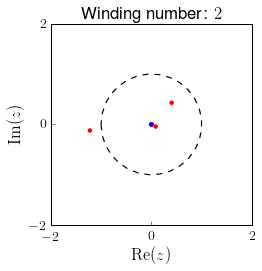
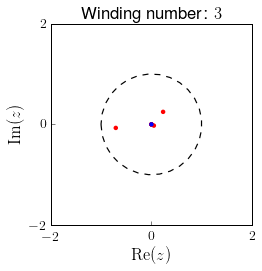
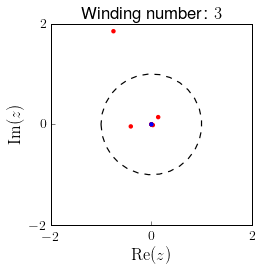
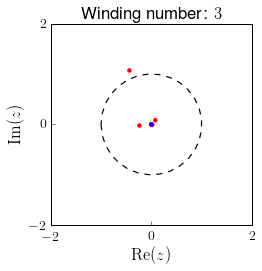
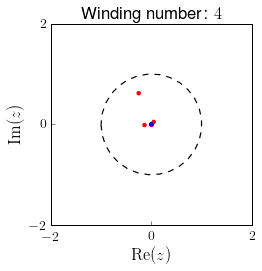
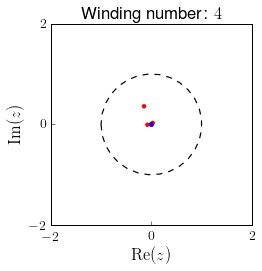
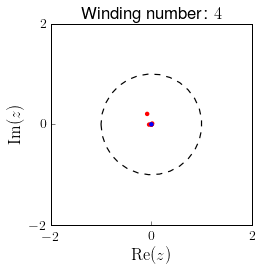

In [5]:
def random_sys(N=4):    
    onsite = randn(N, N) + 1j * randn(N, N)
    lefthopping = randn(N, N) + 1j * randn(N, N)
    righthopping = randn(N, N) + 1j * randn(N, N)
    
    return onsite, lefthopping, righthopping

def find_singularities(onsite, lefthopping, righthopping):
    # We will have a generalized eigenvalue problem. The two matrices alone do not have much of a physical meaning, 
    # so their names are also meaningless: mat1, mat2. 
    n = len(onsite)
    
    mat1 = np.bmat([[onsite, np.eye(n)],
                    [lefthopping, np.zeros((n, n))]])
    
    mat2 = np.bmat([[np.zeros((n, n)), np.zeros((n, n))],
                    [np.zeros((n, n)), -righthopping]])
    
    return scipy.linalg.eigvals(mat2, mat1)

def winding_plot(onsite, lefthopping, righthopping):
    singularities = find_singularities(onsite, lefthopping, righthopping)
    winding = sum(abs(singularities) < 1) - len(onsite)
    circle = np.exp(1j * np.linspace(-np.pi, np.pi, 30))
    title = 'Winding number: ${}$'.format(winding)
    kdims = [r'$\operatorname{Re}(z)$', r'$\operatorname{Im}(z)$']
    pl = holoviews.Path((circle.real, circle.imag), kdims=kdims)(style={'color': 'k', 'linestyle': '--'})
    pl *= holoviews.Points((singularities.real, singularities.imag))(style={'color': 'r'})
    pl *= holoviews.Points((0, 0))(style={'color': 'b'})
    return pl[-2:2, -2:2].relabel(title)(plot={'xticks': 3, 'yticks': 3})

np.random.seed(30)
onsite, lefthopping, righthopping = random_sys()
winding_scale = lambda scale: winding_plot(4 * onsite * 1.2**-abs(scale),
                                           lefthopping * 1.2**scale,
                                           righthopping * 1.2**-scale)

holoviews.HoloMap({scale: winding_scale(scale) for scale in range(-10, 10)})

In the graph above, we see the zeros (red) and poles (blue) of $h(z)$ for some randomly generated system, while we tune a parameter that gradually changes the topology of the system.

The approach of analytic continuation onto a complex plane works whenever we have only one momentum variable, so for any 1D system, or a 2D system where we compute the scattering, and allows to calculate the integral exactly and in one step.

# Real space methods

There is also a broad class of algorithms that rely on the real space structure of the system, and on the inability to deform the wave functions of the filled state into completely localized orbitals.

The intuition behind these is coming from [non-commutative geometry](http://en.wikipedia.org/wiki/Noncommutative_geometry), and so it is very hard to explain intuitively. Let us try to illustrate the logic behind those.

The real space invariants are known for many different [symmetry classes](http://arxiv.org/abs/1012.1019), but for concreteness let's see how they work for the Chern insulators (and accordingly how we can compute the Chern number).

First, let's make a finite but large system in a way that it is fully gapped. Of course if it's topologically non-trivial, we need to remove the edge states, and we'll do this by applying periodic boundary conditions in both $x$- and $y$-directions.

We can now define periodic $x$ and $y$ coordinates $0 < x \leq L$, $0 < y \leq W$. We can make continuous variables out of these by studying phase factors $\varphi_x = \exp(2 \pi i x / L)$, and $\varphi_y = \exp(2 \pi i y / W)$.

The rough idea is as follows. All the filled states in a gapped material can be made localized, but if the system is topological this localization of the states is never exact (since fully localized states would correspond to a trivial Hamiltonian).

Fully localized states would have their $x$ and $y$ coordinates commuting, so we could try to check if we can approximate $x$ and $y$ coordinates of the filled states with commuting matrices.

The $\varphi_x$ and $\varphi_y$ phases of the filled states are operators, and we can calculate them by projecting them onto the space of filled states:

$$
\varPhi_x = \sum_{ij} |\psi_i\rangle\langle \psi_i | \varphi_x | \psi_j\rangle \langle \psi_j|,
$$

$$
\varPhi_y = \sum_{ij} |\psi_i\rangle \langle \psi_i | \varphi_y | \psi_j\rangle \langle \psi_j|.
$$

We now need to determine if $\varPhi_x$ and $\varPhi_y$ approximately commute. Let's consider the expression

$$
\textrm{tr}\left(\log\left(\varPhi_x \varPhi_y \varPhi_x^\dagger \varPhi_y^\dagger\right)\right) = 2\pi i \,m + r\,.
$$

First of all, $m$ is always an integer, because $\text{tr}(\log(A)) = \log(\det(A)),$ and the $\det\left(\varPhi_x \varPhi_y \varPhi_x^\dagger \varPhi_y^\dagger\right) = \det(\varPhi_x)\det^*(\varPhi_x)\det(\varPhi_y)\det^*(\varPhi_y)$, so it is real.

If $\varPhi_x$ and $\varPhi_y$ commute, $m = 0$. It can only change if one of the eigenvalues of $\varPhi_x \varPhi_y \varPhi_x^\dagger \varPhi_y^\dagger$ goes through 0 on a complex plane, which signals appearance of a delocalized mode.

So the **Bott index** $m$ looks like a Chern number, behaves like a Chern number, and it indeed is a Chern number.

To illustrate its behavior let's plot the cumulative sum of the eigenvalues of $\log\varPhi_x \varPhi_y \varPhi_x^\dagger \varPhi_y^\dagger$, taking a disordered Chern insulator as a sample system:

b':HoloMap   [$m$]\n   :Overlay\n      .Path.I   :Path   [x,y]\n      .Points.I :Points   [x,y]'
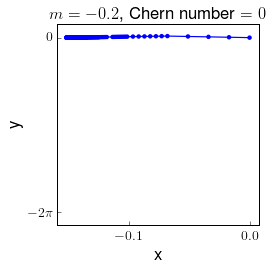
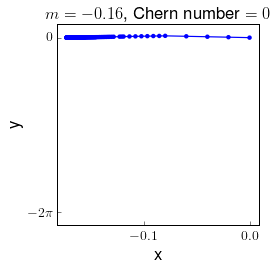
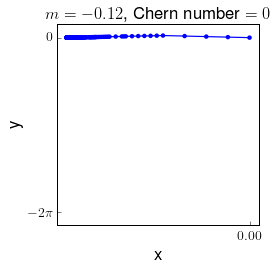
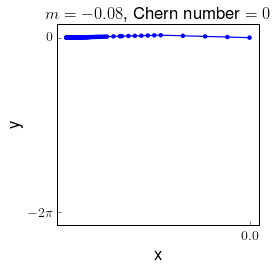
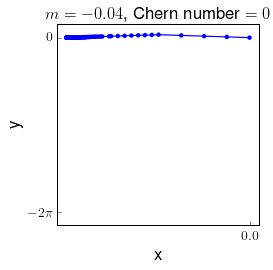
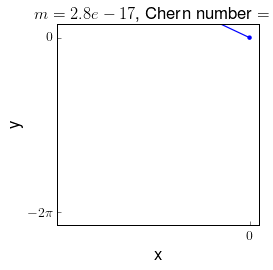
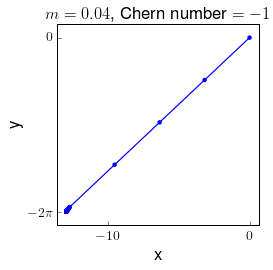
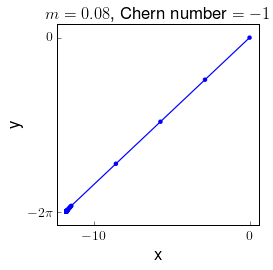
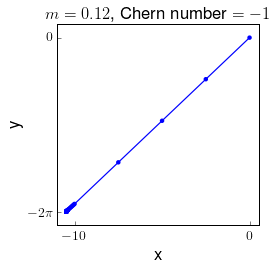
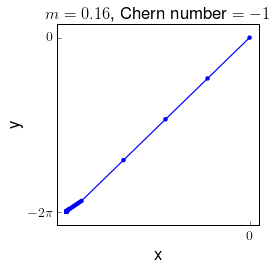
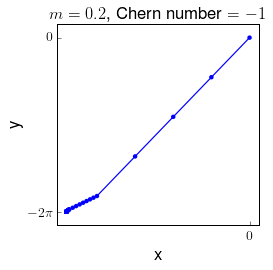
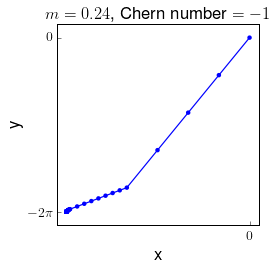
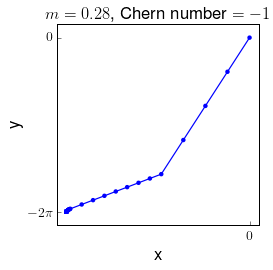
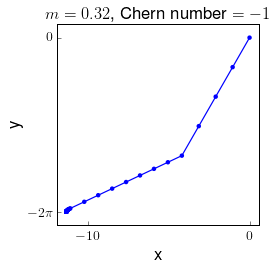
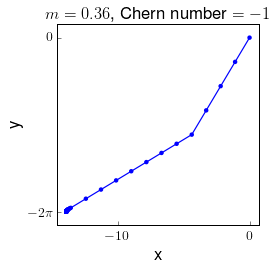
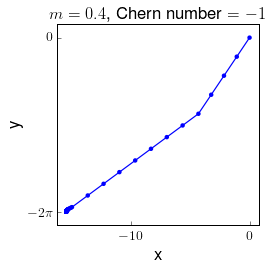

In [6]:
%%opts Points {+framewise}
%%opts Path {+framewise}

p = SimpleNamespace(t=1.0, mu=0.1, delta=0.1, disorder=0.5)
sys = chern_torus(12, 12)

def evaluate_m(sys, p):
    op_x, op_y = projected_operators(sys, p, energy=0.01)
    temp = op_x.dot(op_y).dot(op_x.T.conj()).dot(op_y.T.conj())
    eigs = np.linalg.eigvals(temp)
    # get rid of the four zero eigenvalues
    res = np.sum(np.log(eigs))
    res = res.imag / (2 * np.pi)
    #This calculation is only correct to numerical accuracy.
    #When the Chern number is zero the result might be a very small negative number. 
    #We make them positive so that the out put is never -0, because that does not look nice.
    if abs(res) < 0.5:
        res = abs(res)
    
    xs = np.cumsum(np.log(eigs)).real
    ys = np.cumsum(np.log(eigs)).imag
    
    x = np.append([0], xs)
    y = np.append([0], ys)
    title = '$m={:.2}$, Chern number $={:1.0f}$'.format(p.mu, res)
    window_widening = (max(x) - min(x)) * 0.05
    pl = holoviews.Path((x, y))(style={'color': 'b'})
    pl *= holoviews.Points((x, y))(style={'color': 'b'})
    xlim = slice(min(x) - window_widening, max(x) + window_widening)
    ylim = slice(-2 * np.pi - 0.5, 0.5)
    ticks = {'xticks': 2, 'yticks': [(-2 * np.pi, r'$-2\pi$'), (0, r'$0$')]}
    return pl[xlim, ylim].relabel(title)(plot=ticks)

holoviews.HoloMap({p.mu: evaluate_m(sys, p) for p.mu in np.linspace(-0.2, 0.4, 16)}, kdims=[r'$m$'])

# Conclusions

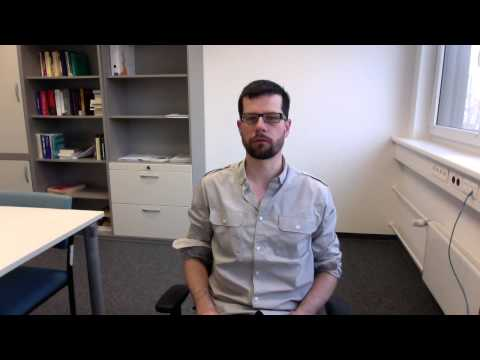

In [7]:
MoocVideo("9qCSXEfSlqE", src_location="8.2-summary")

Questions about what you just learned? Ask them below!

In [8]:
MoocDiscussion("Questions", "Topological invariants")

MoocDiscussion(**{'discussion_id': '7b12d5b1c7782ca7bd43b07fd1e48d37', 'display_name': 'Topological invariants', 'discussion_category': 'Questions', 'discussion_target': 'Topological invariants'})